In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import svm
import hdf5storage
import matplotlib.pyplot as plt
import timeit

In [2]:
ret = {}
for i in range(4):
    ret['losses'+str(i)] =i
    
ret

{'losses0': 0, 'losses1': 1, 'losses2': 2, 'losses3': 3}

In [2]:
data = hdf5storage.loadmat('q1_dataset.mat')

In [11]:
train_hog = data['hog_features_train']
test_hog = data['hog_features_test']
superclass_train = data['superclass_labels_train']
superclass_test = data['superclass_labels_test']
train_network = data['inception_features_train']
test_network = data['inception_features_test']
subclass_train = data['subclass_labels_train']

In [4]:
train_hog.shape

(2000, 324)

In [5]:
def sigmoid(z):
    a = 1/(1+np.e**(-z))
    a = a.T
    return a
def likelihood(X,y,w):
    acc_sum = 0
    for i in range(len(X)):
        z = np.dot(w.T,X[i])
        acc_sum += (y[i]*(z)-math.log(1 + math.exp(z)))
    return acc_sum/len(X)

def forward(X,w):
    z = w.T.dot(X.T)
    return np.array(sigmoid(z))


def update(X,y,w,lr):
    
    predictions = forward(X,w)
        
    updt = np.dot(X.T, (y - predictions ))
    
    updt = updt / len(X)
    
    updt *= lr
    
    w = w + updt
    
    return w

def create_k_folds(X, y, k): 
    k_folds = [] 
    data = np.hstack((X, y)) 
    np.random.shuffle(data) 
    n_folds = data.shape[0] // k

    for i in range(n_folds): 
        fold = data[i * k:(i + 1)*k, :] 
        X_folded = fold[:, :-1] 
        Y_folded = fold[:, -1].reshape((-1, 1)) 
        k_folds.append((X_folded, Y_folded)) 
        
    if data.shape[0] % k != 0: 
        fold = data[i * k:data.shape[0]] 
        new_X = fold[:, :-1] 
        new_Y= fold[:, -1].reshape((-1, 1)) 
        k_folds.append((new_X, new_Y)) 
    return k_folds
def calculate_performance_metrics(predictions,true_labels):
    check = predictions == true_labels
    count = 0
    for i in range(len(check)):
        if check[i] == True: 
            count += 1 
    accuracy = count / len(superclass_test)
    c_matrix = confusion_matrix(superclass_test, predictions)
    print('Confusion Matrix: \n [0,0] is TN - [1,1] is TP - [0,1] FP - [1,0] FN \n' , c_matrix)
    print('accuracy = ' + str(accuracy))
    precision = c_matrix[1][1] / (c_matrix[1][1] + c_matrix[0][1])
    print('precision = ' + str(precision))
    recall = c_matrix[1][1] / (c_matrix[1][1] + c_matrix[1][0])
    print('recall = ' + str(recall))
    NPR = c_matrix[0][0] / (c_matrix[0][0] + c_matrix[1][0])
    print('NPV = ' + str(NPR))
    FPR = c_matrix[0][1] / (c_matrix[0][1] + c_matrix[0][0])
    print('FPR = ' + str(FPR))
    FDR = (c_matrix[0][1] + c_matrix[1][0] )/ (len(predictions))
    print('FDR = ' + str(FDR))
    F1 = 2* precision* recall / (precision + recall)
    print('F1 score = ' + str(F1))
    F2 = 5* precision * recall / (4*precision + recall)
    print('F2 score = ' + str(F2))
    return accuracy

def train_full_batch(X, Y, weights, lr, iters):
    list_of_costs = []
    for i in range(iters):
        weights = update(X, Y, weights, lr)
        cost = likelihood(X, Y, weights)
        list_of_costs.append(cost)
        
        if i % 100 == 0:
            print ( str(i) + ' epoch - ' + 'likelihood: ' + str(cost))

    return weights, list_of_costs
    
def train_mini_batches(X, Y, weights, lr, iters,batchsize):
    list_of_costs = []
    for i in range(iters):
        minibatches = create_k_folds(X,Y,batchsize)
        for m in minibatches:
            mini_x, mini_y = m
            weights = update(mini_x, mini_y, weights, lr)
            cost = likelihood(mini_x, mini_y, weights)
            list_of_costs.append(cost)
        
        if i % 100 == 0:
            print ( str(i) + ' epoch - ' + 'likelihood: ' + str(cost))

    return weights, list_of_costs

In [10]:
#TRAINING WITH HOG DATA FOR SUPERCLASS LOGISTIC REGRESSION
start = timeit.default_timer()
initialized_weights= np.random.normal(0,0.01,train_hog.shape[1])
initialized_weights = initialized_weights.reshape(train_hog.shape[1],1)
weights_trained, cost = train_mini_batches(train_hog,superclass_train,initialized_weights,lr = 0.01, iters =1000, batchsize=25)

predictions = forward(test_hog,weights_trained)
predictions = predictions.round()

calculate_performance_metrics(predictions,superclass_test)

stop = timeit.default_timer()
print('Time: ', stop - start)  

0 epoch - likelihood: [-0.68816298]
100 epoch - likelihood: [-0.61797222]
200 epoch - likelihood: [-0.53994972]
300 epoch - likelihood: [-0.46335272]
400 epoch - likelihood: [-0.63753385]
500 epoch - likelihood: [-0.64877388]
600 epoch - likelihood: [-0.62959971]
700 epoch - likelihood: [-0.51409078]
800 epoch - likelihood: [-0.61294176]
900 epoch - likelihood: [-0.48630027]
Confusion Matrix: 
 [0,0] is TN - [1,1] is TP - [0,1] FP - [1,0] FN 
 [[139  61]
 [ 74 126]]
accuracy = 0.6625
precision = 0.6737967914438503
recall = 0.63
NPV = 0.6525821596244131
FPR = 0.305
FDR = 0.3375
F1 score = 0.6511627906976745
F2 score = 0.6382978723404256
Time:  27.838466400000016


In [123]:
#TRAINING NEURAL NETWORK DATA FOR SUPERCLASS WITH LOGISTIC REGRESSION
#100 olan iteration sayısını 1000 yapman lazım Bilge zaman alıyo çok diye yapmadım raporu yazarken yap
start = timeit.default_timer()
initialized_weights= np.random.normal(0,0.01,train_network.shape[1])
initialized_weights = initialized_weights.reshape(train_network.shape[1],1)
weights_trained, cost = train_mini_batches(train_network,superclass_train,initialized_weights,lr = 0.01, iters =100, batchsize=25)

predictions = forward(test_network,weights_trained)
predictions = predictions.round()
calculate_performance_metrics(predictions,superclass_test)

stop = timeit.default_timer()
print('Time: ', stop - start)  

0 epoch - likelihood: [-0.34490579]
Confusion Matrix: 
 [[170  30]
 [ 19 181]]
accuracy = 0.8775
precision = 0.8578199052132701
recall = 0.905
NPV = 0.8994708994708994
FPR = 0.15
FDR = 0.1225
Time:  28.342405599999893


In [125]:
#FULL BATCH TRAINING NEURAL NETWORK DATA FOR SUPERCLASS WITH LOGISTIC REGRESSION
start = timeit.default_timer()
initialized_weights= np.random.normal(0,0.01,train_network.shape[1])
initialized_weights = initialized_weights.reshape(train_network.shape[1],1)
weights_trained, cost = train_full_batch(train_network,superclass_train,initialized_weights,lr = 0.01, iters =1000)

predictions = forward(test_network,weights_trained)
predictions = predictions.round()

calculate_performance_metrics(predictions,superclass_test)
stop = timeit.default_timer()
print('Time: ', stop - start)  

0 epoch - likelihood: [-0.68886057]
100 epoch - likelihood: [-0.3630513]
200 epoch - likelihood: [-0.31367276]
300 epoch - likelihood: [-0.28974463]
400 epoch - likelihood: [-0.27437702]
500 epoch - likelihood: [-0.26317824]
600 epoch - likelihood: [-0.25439831]
700 epoch - likelihood: [-0.24717648]
800 epoch - likelihood: [-0.24103234]
900 epoch - likelihood: [-0.23567373]
Confusion Matrix: 
 [[174  26]
 [ 22 178]]
accuracy = 0.88
precision = 0.8725490196078431
recall = 0.89
NPV = 0.8877551020408163
FPR = 0.13
FDR = 0.12
Time:  66.91423309999982


In [126]:
#FULL BATCH TRAINING HOG DATA FOR SUPERCLASS WITH LOGISTIC REGRESSION
start = timeit.default_timer()
initialized_weights= np.random.normal(0,0.01,train_hog.shape[1])
initialized_weights = initialized_weights.reshape(train_hog.shape[1],1)
weights_trained, cost = train_full_batch(train_hog,superclass_train,initialized_weights,lr = 0.01, iters =1000)

predictions = forward(test_hog,weights_trained)
predictions = predictions.round()

calculate_performance_metrics(predictions,superclass_test)
stop = timeit.default_timer()
print('Time: ', stop - start)  

0 epoch - likelihood: [-0.69266249]
100 epoch - likelihood: [-0.69013407]
200 epoch - likelihood: [-0.68770889]
300 epoch - likelihood: [-0.68536378]
400 epoch - likelihood: [-0.68308989]
500 epoch - likelihood: [-0.6808828]
600 epoch - likelihood: [-0.67873952]
700 epoch - likelihood: [-0.67665753]
800 epoch - likelihood: [-0.67463455]
900 epoch - likelihood: [-0.67266841]
Confusion Matrix: 
 [[147  53]
 [ 87 113]]
accuracy = 0.65
precision = 0.6807228915662651
recall = 0.565
NPV = 0.6282051282051282
FPR = 0.265
FDR = 0.35
Time:  12.875383799999781


In [13]:
#SVM TRAINING METHODS

#Divides the data into k folds to prepare for cross validation
def stratified_k_folds(X, y, k): 
    k_folds = [] 
    data = np.hstack((X, y)) 
    np.random.shuffle(data)
    data_size = data.shape[0] // k

    for i in range(k): 
        fold = data[i * data_size:(i + 1)*data_size, :] 
        X_folded = fold[:, :-1] 
        Y_folded = fold[:, -1].reshape((-1, 1)) 
        k_folds.append((X_folded, Y_folded)) 
        
    if data.shape[0] % k != 0: 
        fold = data[i * data_size:data.shape[0]] 
        new_X = fold[:, :-1] 
        new_Y= fold[:, -1].reshape((-1, 1)) 
        k_folds.append((new_X, new_Y)) 
    return k_folds

#Trains linear soft margin
def trainSVM(X,y,c,folds):
    clssvm = svm.SVC(kernel='linear',C=c)
    k_folds = stratified_k_folds(X,y,folds)
    features = []
    labels = []
    for f in k_folds:
        fet, lab = f
        features.append(fet)
        labels.append(lab)
    accuracy = 0
    for i,f in enumerate(k_folds):
        
        xtest, ytest = f
        tempf = np.delete(np.array(features),i,axis= 0)
        templ = np.delete(np.array(labels),i, axis = 0)
        xtrain = np.stack(tempf)
        xtrain = xtrain.reshape(((folds-1) * xtrain.shape[1], X.shape[1]))
        ytrain = np.stack(templ)
        ytrain = ytrain.reshape(((folds-1) * ytrain.shape[1], y.shape[1]))
        clssvm.fit(xtrain,ytrain)
        predictions = clssvm.predict(xtest)
        predictions=predictions.reshape((len(predictions), 1))
        print(i+1, '. FOLD')
        accuracy += calculate_performance_metrics(predictions,ytest)
    print('----------------------------FINISHED--------------------------------------')
    print('MEAN ACCURACY: ', accuracy / len(k_folds))
    return
        

In [128]:
start = timeit.default_timer()
trainSVM(train_hog,superclass_train,1,5)
stop = timeit.default_timer()
print('Time: ', stop - start)  

C:\Users\tahir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1 . FOLD
Confusion Matrix: 
 [[104  96]
 [103  97]]
accuracy = 0.6725
precision = 0.5025906735751295
recall = 0.485
NPV = 0.5024154589371981
FPR = 0.48
FDR = 0.4975


C:\Users\tahir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2 . FOLD
Confusion Matrix: 
 [[105  95]
 [101  99]]
accuracy = 0.665
precision = 0.5103092783505154
recall = 0.495
NPV = 0.5097087378640777
FPR = 0.475
FDR = 0.49


C:\Users\tahir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3 . FOLD
Confusion Matrix: 
 [[110  90]
 [108  92]]
accuracy = 0.685
precision = 0.5054945054945055
recall = 0.46
NPV = 0.5045871559633027
FPR = 0.45
FDR = 0.495


C:\Users\tahir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4 . FOLD
Confusion Matrix: 
 [[ 92 108]
 [102  98]]
accuracy = 0.6525
precision = 0.47572815533980584
recall = 0.49
NPV = 0.4742268041237113
FPR = 0.54
FDR = 0.525


C:\Users\tahir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5 . FOLD
Confusion Matrix: 
 [[105  95]
 [100 100]]
accuracy = 0.665
precision = 0.5128205128205128
recall = 0.5
NPV = 0.5121951219512195
FPR = 0.475
FDR = 0.4875
----------------------------FINISHED--------------------------------------
MEAN ACCURACY:  0.6679999999999999
Time:  4.3544038


In [14]:
#SUB CLASS WITH SVM
start = timeit.default_timer()
trainSVM(train_hog,subclass_train,1,5)
stop = timeit.default_timer()
print('Time: ', stop - start)  

C:\Users\tahir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1 . FOLD
Confusion Matrix: 
 [0,0] is TN - [1,1] is TP - [0,1] FP - [1,0] FN 
 [[19 34 15 21 19 17 30 14 10 21]
 [25 22 16 23 20 21 24 11 18 20]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
accuracy = 0.34
precision = 0.39285714285714285
recall = 0.46808510638297873
NPV = 0.4318181818181818
FPR = 0.6415094339622641
FDR = 0.1475
F1 score = 0.4271844660194175
F2 score = 0.4508196721311475


C:\Users\tahir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2 . FOLD
Confusion Matrix: 
 [0,0] is TN - [1,1] is TP - [0,1] FP - [1,0] FN 
 [[26 32 32 18 15 18 17 10 13 19]
 [28 25 17 18 18 23 15 15 17 24]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
accuracy = 0.34
precision = 0.43859649122807015
recall = 0.4716981132075472
NPV = 0.48148148148148145
FPR = 0.5517241379310345
FDR = 0.15
F1 score = 0.45454545454545453
F2 score = 0.4646840148698884


C:\Users\tahir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3 . FOLD
Confusion Matrix: 
 [0,0] is TN - [1,1] is TP - [0,1] FP - [1,0] FN 
 [[20 26 20 24 28 25 24  8 12 13]
 [15 31 26 16 21 16 16 15 21 23]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
accuracy = 0.2675
precision = 0.543859649122807
recall = 0.6739130434782609
NPV = 0.5714285714285714
FPR = 0.5652173913043478
FDR = 0.1025
F1 score = 0.6019417475728156
F2 score = 0.6431535269709544


C:\Users\tahir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4 . FOLD
Confusion Matrix: 
 [0,0] is TN - [1,1] is TP - [0,1] FP - [1,0] FN 
 [[36 22 20 12 18 27 21 13 14 17]
 [26 26 22 24 25 22 17  9 14 15]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
accuracy = 0.285
precision = 0.5416666666666666
recall = 0.5
NPV = 0.5806451612903226
FPR = 0.3793103448275862
FDR = 0.12
F1 score = 0.52
F2 score = 0.5078125


C:\Users\tahir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5 . FOLD
Confusion Matrix: 
 [0,0] is TN - [1,1] is TP - [0,1] FP - [1,0] FN 
 [[28 14 21 30 26 19 19  9 18 16]
 [23 32 28 17 17 18 16 12 24 13]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
accuracy = 0.28
precision = 0.6956521739130435
recall = 0.5818181818181818
NPV = 0.5490196078431373
FPR = 0.3333333333333333
FDR = 0.0925
F1 score = 0.6336633663366337
F2 score = 0.6015037593984962
----------------------------FINISHED--------------------------------------
MEAN ACCURACY:  0.3025
Time:  5.953504199999998


In [159]:
data = hdf5storage.loadmat('q2_dataset.mat')
data = data['data'].reshape((data['data'].shape[0], data['data'].shape[1] * data['data'].shape[2]))

In [162]:
#CALCULATING PCA BY COVARIANCE MATRIX
start = timeit.default_timer()
from sklearn.preprocessing import StandardScaler
data = StandardScaler().fit_transform(data)
cov = np.cov(data)
eig_val, eig_vec = np.linalg.eig(cov)
eig_pairs = [(np.abs(eig_val[i]), eig_vec[:,i]) for i in range(len(eig_val))]

W = np.array(eig_vec[0])
W = W.reshape((150,1))
for i in range(len(eig_pairs)):
    if i >0:
        W = np.hstack((W,eig_vec[i].reshape((eig_vec.shape[0], 1))))
reconstruct = np.matmul(W,data)
print('MEAN SQUARED ERROR FOR COVARIANCE = ',np.sum(np.square(reconstruct - data)) / len(reconstruct))
stop = timeit.default_timer()
print('Time: ', stop - start)  

1
(150, 2)
2
(150, 3)
3
(150, 4)
4
(150, 5)
5
(150, 6)
6
(150, 7)
7
(150, 8)
8
(150, 9)
9
(150, 10)
10
(150, 11)
11
(150, 12)
12
(150, 13)
13
(150, 14)
14
(150, 15)
15
(150, 16)
16
(150, 17)
17
(150, 18)
18
(150, 19)
19
(150, 20)
20
(150, 21)
21
(150, 22)
22
(150, 23)
23
(150, 24)
24
(150, 25)
25
(150, 26)
26
(150, 27)
27
(150, 28)
28
(150, 29)
29
(150, 30)
30
(150, 31)
31
(150, 32)
32
(150, 33)
33
(150, 34)
34
(150, 35)
35
(150, 36)
36
(150, 37)
37
(150, 38)
38
(150, 39)
39
(150, 40)
40
(150, 41)
41
(150, 42)
42
(150, 43)
43
(150, 44)
44
(150, 45)
45
(150, 46)
46
(150, 47)
47
(150, 48)
48
(150, 49)
49
(150, 50)
50
(150, 51)
51
(150, 52)
52
(150, 53)
53
(150, 54)
54
(150, 55)
55
(150, 56)
56
(150, 57)
57
(150, 58)
58
(150, 59)
59
(150, 60)
60
(150, 61)
61
(150, 62)
62
(150, 63)
63
(150, 64)
64
(150, 65)
65
(150, 66)
66
(150, 67)
67
(150, 68)
68
(150, 69)
69
(150, 70)
70
(150, 71)
71
(150, 72)
72
(150, 73)
73
(150, 74)
74
(150, 75)
75
(150, 76)
76
(150, 77)
77
(150, 78)
78
(150, 79)
79


In [164]:
#RECONSTRUCTED IMAGES WITH SINGULAR VALUE DECOMPOSITION
start = timeit.default_timer()
U,S,V = np.linalg.svd(data)
W = np.array(U[0])
W = W.reshape((150,1))
for i in range(len(U)):
    if i >0:
        W = np.hstack((W,U[i].reshape((U.shape[0], 1))))
        print(i)
        print(W.shape)
reconstructSVD = W.dot(data)
print('MEAN SQUARED ERROR FOR SVD = ',np.sum(np.square(reconstructSVD - data)) / len(reconstructSVD))
stop = timeit.default_timer()
print('Time: ', stop - start)  

1
(150, 2)
2
(150, 3)
3
(150, 4)
4
(150, 5)
5
(150, 6)
6
(150, 7)
7
(150, 8)
8
(150, 9)
9
(150, 10)
10
(150, 11)
11
(150, 12)
12
(150, 13)
13
(150, 14)
14
(150, 15)
15
(150, 16)
16
(150, 17)
17
(150, 18)
18
(150, 19)
19
(150, 20)
20
(150, 21)
21
(150, 22)
22
(150, 23)
23
(150, 24)
24
(150, 25)
25
(150, 26)
26
(150, 27)
27
(150, 28)
28
(150, 29)
29
(150, 30)
30
(150, 31)
31
(150, 32)
32
(150, 33)
33
(150, 34)
34
(150, 35)
35
(150, 36)
36
(150, 37)
37
(150, 38)
38
(150, 39)
39
(150, 40)
40
(150, 41)
41
(150, 42)
42
(150, 43)
43
(150, 44)
44
(150, 45)
45
(150, 46)
46
(150, 47)
47
(150, 48)
48
(150, 49)
49
(150, 50)
50
(150, 51)
51
(150, 52)
52
(150, 53)
53
(150, 54)
54
(150, 55)
55
(150, 56)
56
(150, 57)
57
(150, 58)
58
(150, 59)
59
(150, 60)
60
(150, 61)
61
(150, 62)
62
(150, 63)
63
(150, 64)
64
(150, 65)
65
(150, 66)
66
(150, 67)
67
(150, 68)
68
(150, 69)
69
(150, 70)
70
(150, 71)
71
(150, 72)
72
(150, 73)
73
(150, 74)
74
(150, 75)
75
(150, 76)
76
(150, 77)
77
(150, 78)
78
(150, 79)
79


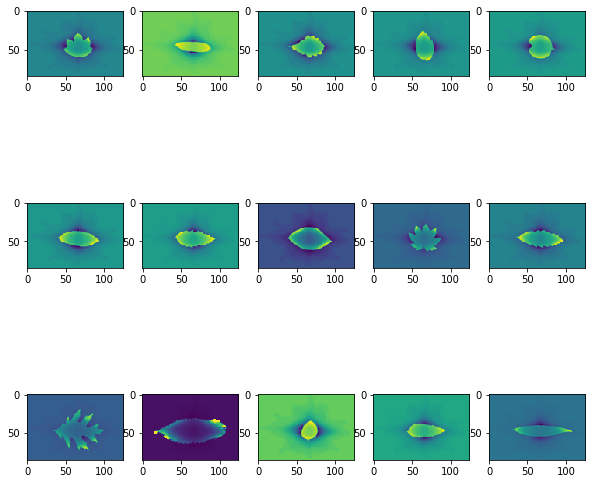

In [156]:
#REAL DATA IMAGES
data = data.reshape((150,85,125))
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(data[i])
plt.show()

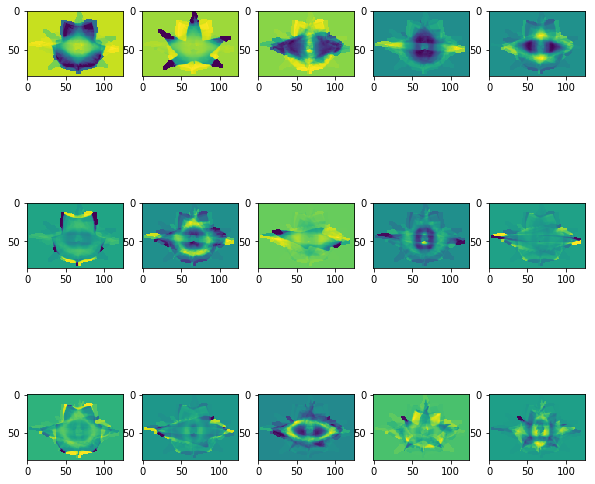

In [163]:
reconstruct = reconstruct.reshape((150,85,125))
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(15):
    plt.subplot(3,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(reconstruct[i])
plt.show()

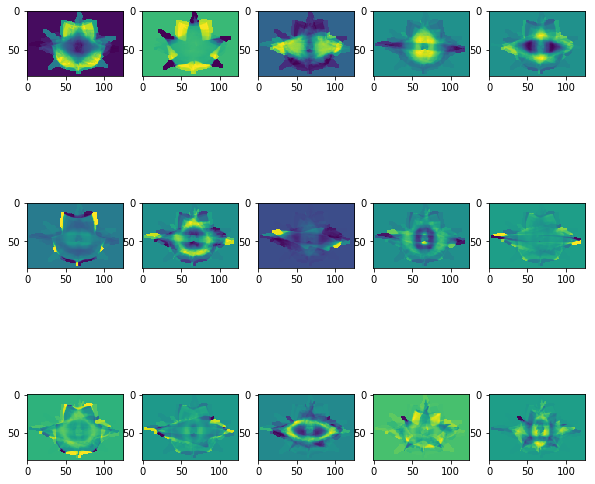

In [165]:
reconstructSVD = reconstructSVD.reshape((150,85,125))
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(15):
    plt.subplot(3,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(reconstructSVD[i])
plt.show()